# Visualising the Fire Weather Index (FWI) for the European State of the Climate (ESOTC) assesment

<div class="alert alert-block alert-info">
<b>Note:</b> If you're running this notebook on ATOS using ecinteractive, make sure that you started it with at least 16 GB ram memory, otherwise it will crash at some point. You can set the memory by running "ecinteractive -j -m 16".
</div>

Before we begin, we must prepare our enviroment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries we will need. To install the CDS API, run the following command:

In [22]:
# Only need to be run once
!pip -q install cdsapi # only needs to be installed once

 ### Importing all the necessary python libraries:

In [23]:
import os
import zipfile

# CDS API
import cdsapi

# working with multidimensional arrays
import xarray as xr

# libraries for plotting and visualising the data
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 25})

# Search and download the data

### Enter your CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: URL and KEY, which build together your CDS API key. The string of characters that make up your KEY includes your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after “key:”. Replace the ######### below with this string.

If you have set up your cdsapi key using a ~/.cdsapirc the following is not required and cdsapi_kwargs can be left as an empty dictionary.

In [17]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'
cdsapi_kwargs = {
    # 'url': URL,
    # 'key': KEY,
}

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [18]:
# Only need to be run once
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

## Find the fire danger indices historical data

In this notebook we calculate and plot the diffrence between number of days when FWI>50 in 2022 and mean number between 2015-2020. The data can be found in [Fire danger indices historical data from the Copernicus Emergency Management Service](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-fire-historical?tab=form)

<div class="alert alert-block alert-info">
<b>Note:</b> In this example we're using only 5 years (2015-2020), but for a climatology, ideally it's advided to use years 1991-2022.
</div>

For this example, we are using the following selection on the download page:
- **Product Type** : 'Reanalysis',
- **Varaiable** : 'Fire Weather Index',
- **Version** : '4.0',
- **Dataset** : 'Consolidated Dataset',
- **Year** : '2015-2020',
- **Month** : 'January - December',
- **Day** : '1-31',
- **Format** : 'Zip file (.zip)',


After filling out the download form, select "**Show API request**". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook. One important thing before being able to download the request, is to accept the **Terms of use** in the cell just before the API request. Having double checked your request, and accepted the terms of use, your request is as follows:

In [19]:
# if you're not changing the request, only need to be run once
# Choose the name and location of the donwload file
download_file = f"{DATADIR}/download.zip"
if not os.path.isfile(download_file):
    c = cdsapi.Client(
        **cdsapi_kwargs
    )

# The CDS request based on your selections for this example:b

c = cdsapi.Client()

c.retrieve(
    'cems-fire-historical',
    {
        'format': 'zip',
        'product_type': 'reanalysis',
        'variable': 'fire_weather_index',
        'version': '4.0',
        'dataset': 'Consolidated dataset',
        'year': [
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
    },
    download_file)

2023-03-22 16:42:27,547 INFO Welcome to the CDS
2023-03-22 16:42:27,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-fire-historical
2023-03-22 16:42:27,687 INFO Request is completed
2023-03-22 16:42:27,689 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data5/dataset-cems-fire-historical-6a516064-7c0e-48a2-9372-e6f6da4f6543.zip to ./data_dir/download.zip (1.4G)
2023-03-22 16:51:24,034 INFO Download rate 2.8M/s                                                                                                                                                                                      


Result(content_length=1548503740,content_type=application/zip,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data5/dataset-cems-fire-historical-6a516064-7c0e-48a2-9372-e6f6da4f6543.zip)

### Extracting the zip file:

Now that we downloaded the data, we can extract the netCDF files to a different folder using the zipfile library. Because of the amount of files (1 per day for 5 years), we're unzipping the files to a separate folder (data_dir/2015_2020):

In [22]:
# If you already extracted the data, only need to be run once
with zipfile.ZipFile('data_dir/download.zip', 'r') as zip_ref:
    zip_ref.extractall('data_dir/2015_2020')

## Section 1: Loading global data with Xarray

Depending on how many years you choose, you may run out of memory. 

There's an option to use the global grid, or to slice your grid into a smaller area (Section 2 in this Notebook). 

In [24]:
# For a global grid:
ds = xr.open_mfdataset('data_dir/2015_2020/ECMWF_FWI_FWI_????????_1200_hr_v4.0_con.nc', parallel = True)

### Calculations

Choose reference Fire Weather Index reference value

In [27]:
ref_fwi = 50 # I don't think this value is being used

First we filter out the time period we want to analyse. Here it is from the 1st of May 2020, to the 30th of September 2020.

In [61]:
last_y = ds.sel(time = slice('2020-05-01T12:00:00.000000000','2020-09-30T12:00:00.000000000'))
last_y

<xarray.Dataset>
Dimensions:    (time: 153, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 2020-05-01T12:00:00 ... 2020-09-30T12:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    fwi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   Sat Jul 31 15:11:53 2021: cdo -f nc4 -chname,f...
    institution:               European Centre for Medium-Range Weather Forec...
    cdo_openmp_thread_number:  8
    CDO:                       Climate Data Operators version 1.9.8 (https://...

Next we calculate the number of days where FWI>50

In [40]:
fwi_over50_2020 = last_y.fwi.where(last_y.fwi > 50).groupby('time.year').count(dim = 'time')
fwi_over50_2020

<xarray.DataArray 'fwi' (year: 1, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(1, 721, 1440), dtype=int64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year       (year) int64 2020

We need to do the same for the entire period (or the climatological data).  
First, we filter the May-September period for 2015 and calculate the number of days where FWI>50.  

In [73]:
fwi_data_summer = ds.sel(time = slice('2015-05-01', '2015-09-30'))
fwi_over50 = fwi_data_summer.fwi.where(fwi_data_summer.fwi > 50).groupby('time.year').count(dim='time')

We repeat that for all the years and concatenate them.

In [74]:
for year in range(2015,2019): # range is first year to the last year -1
    fwi_data = ds.sel(time  =slice(f'{year}-05-01', f'{year}-09-30'))
    x = fwi_data.fwi.where(fwi_data.fwi>50).groupby('time.year').count(dim='time')
    fwi_over50 = xr.concat([fwi_over50, x], dim='year')
fwi_over50

<xarray.DataArray 'fwi' (year: 5, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(5, 721, 1440), dtype=int64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year       (year) int64 2015 2015 2016 2017 2018

Now we can calculate average number of days when FWI>50

In [75]:
fwi_over50_mean = fwi_over50.mean(dim='year')
fwi_over50_mean

<xarray.DataArray 'fwi' (latitude: 721, longitude: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

And the anomaly is the difference between these two.  
Note that the 2020 data has year as dimension, so we need to remove it by selecting it beforwe we can calculate the difference.

In [76]:
anom = fwi_over50_2020.sel(year=2020) - fwi_over50_mean
anom

<xarray.DataArray 'fwi' (latitude: 109, longitude: 101)>
dask.array<sub, shape=(109, 101), dtype=float64, chunksize=(109, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 72.0 71.75 71.5 71.25 ... 45.5 45.25 45.0
  * longitude  (longitude) float64 15.0 15.25 15.5 15.75 ... 39.5 39.75 40.0
    year       int64 2020

## Plotting

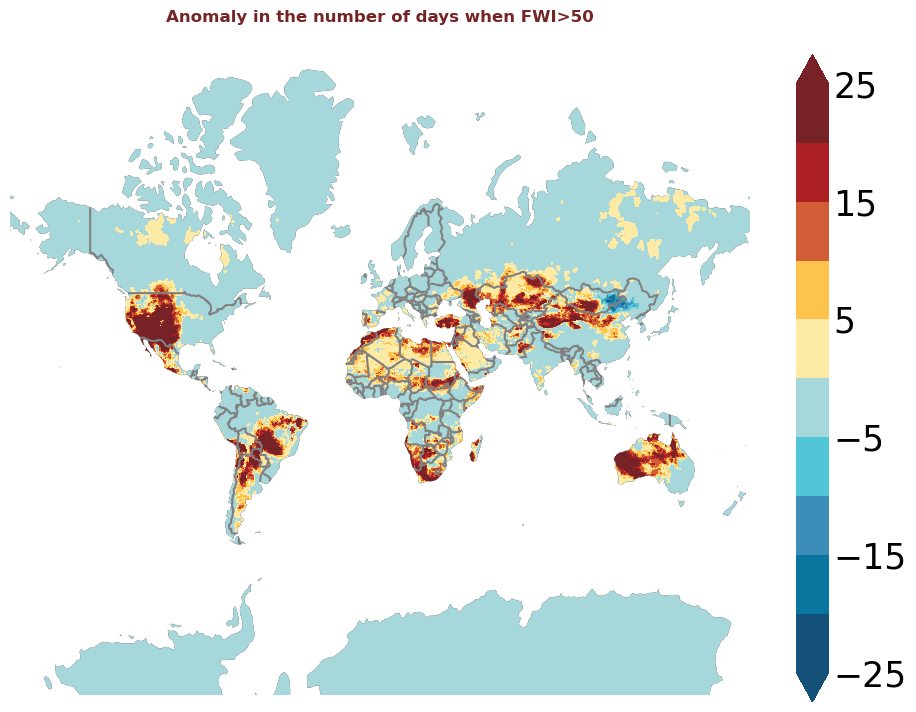

In [44]:
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.Mercator())

ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
ax.add_feature(cart.feature.BORDERS, edgecolor='grey', lw=1.5)
#ax.set_extent ((-15, 40, 34, 70), ccrs.PlateCarree())

redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
# Create the custom colormap
my_cmap = (colors.ListedColormap(redblue))
my_cmap.set_over('#772227')
my_cmap.set_under('#135178')

# Specify the number of discrete levels to use in the colormap
bounds = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
norm = colors.BoundaryNorm(bounds, my_cmap.N)

# Plot data with contours and shading
img = anom.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=11, extend='both',
                         add_colorbar=False, add_labels=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=bounds[::2] )
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#Add coastlines and title, remove black frame
ax.coastlines()
ax.set_frame_on(False)
plt.title("Anomaly in the number of days when FWI>50", fontsize=12, fontweight='bold', y=1.05, color='#742425')
plt.tight_layout()
#plt.savefig('./fwi_anom_europe_v_nowhite.tiff', format='tiff',facecolor='white')

And here is the code for the version with white values between -1 and 1.

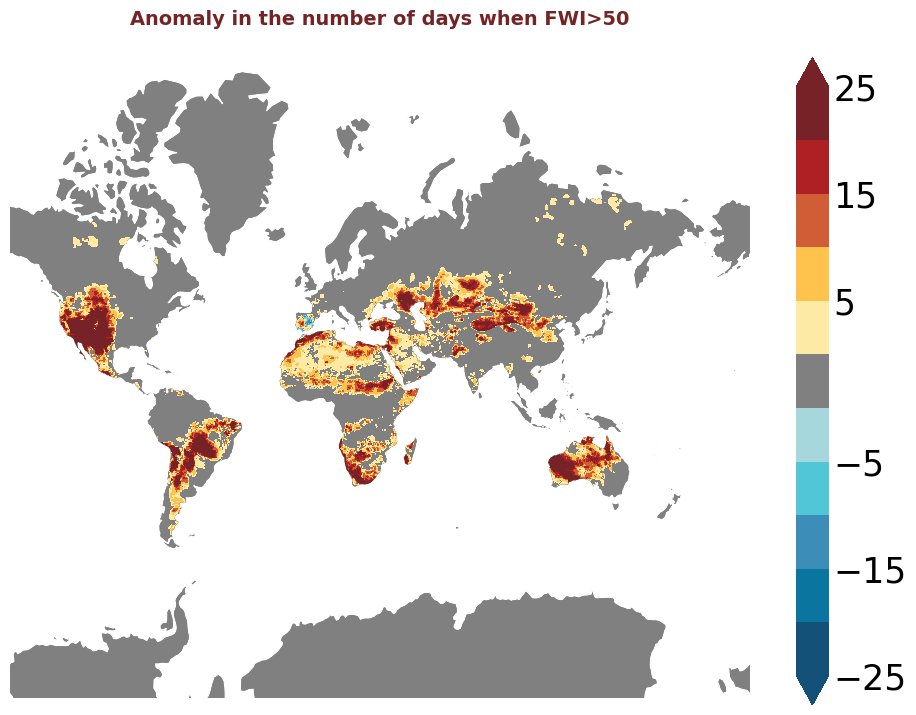

In [45]:
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.Mercator(32))

ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
#ax.set_extent ((-10, 50, 34, 70), ccrs.PlateCarree())
redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db','grey', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
# Create the custom colormap
my_cmap = (colors.ListedColormap(redblue))
my_cmap.set_over('#772227')
my_cmap.set_under('#135178')



# Specify the number of discrete levels to use in the colormap
bounds = [-25, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 25]
norm = colors.BoundaryNorm(bounds, my_cmap.N)

# Plot data with contours and shading
img = anom.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=11, extend='both',
                         add_colorbar=False, add_labels=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=[-25, -15, -5, 5, 15, 25] )
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#Add coastlines and title, remove black frame
ax.coastlines()
ax.set_frame_on(False)
plt.title("Anomaly in the number of days when FWI>50", fontsize=14, fontweight='bold', y=1.05, color='#742425')
plt.tight_layout()
#plt.savefig('./fwi_anom_europe_with_white.png',facecolor='white')

### Second part: ESOTC Regions

### ESOTC Regions
Europe: 25°W–40°E, 34°–72°N <br>
Southwestern Europe: 25°W–15°E, 34°–45°N <br>
Northwestern Europe: 25°W–15°E, 45°–72°N <br>
Southeastern Europe: 15°–40°E, 34°–45°N <br>
Northeastern Europe: 15°–40°E, 45°–72°N <br>
Central Europe: 2°–24°E, 45°–55°N

In [55]:
esotc_regions={'Europe':[-25,40,72,34,0,20],
            'Southwestern Europe':[-25,15,45,34,0,45],
            'Northwestern Europe':[-25,15,72,45,0,20],
            'Southeastern Europe':[15,40,45,34,0,45],
            'Northeastern Europe':[15,40,72,45,0,20]}

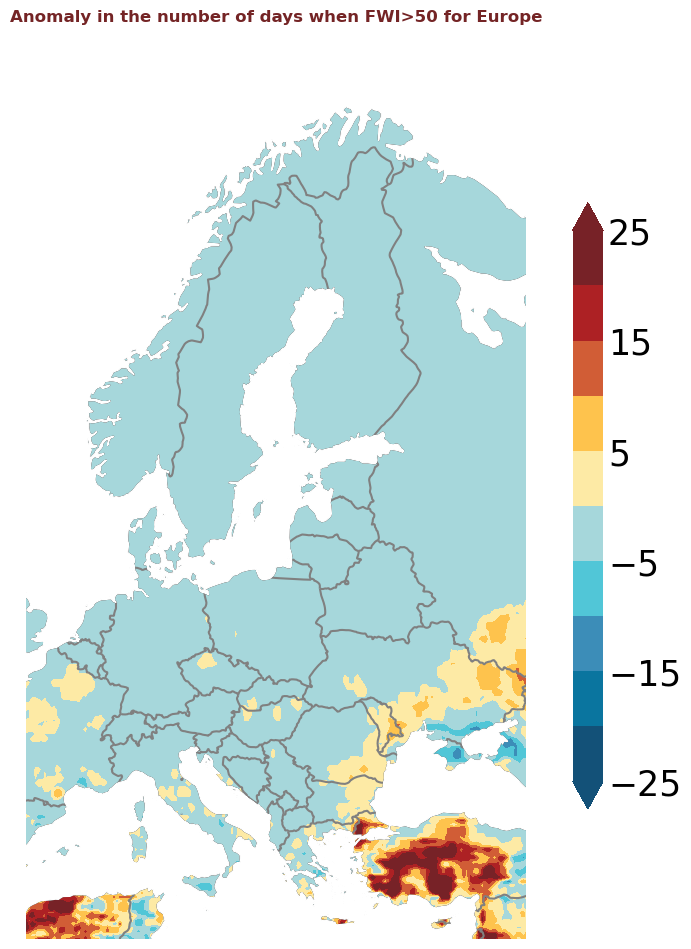

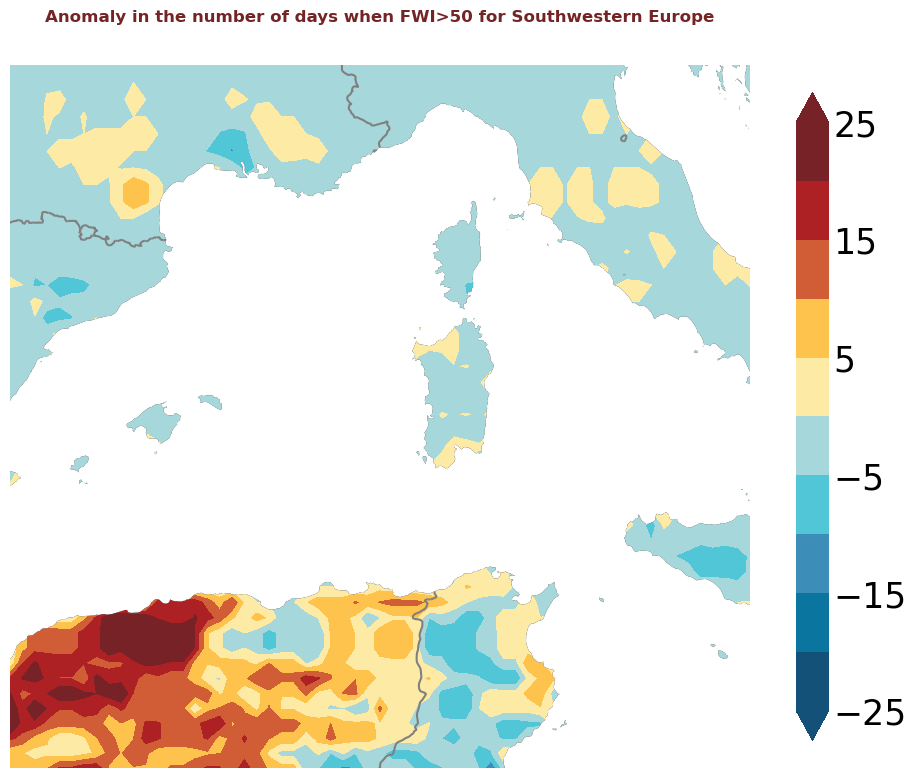

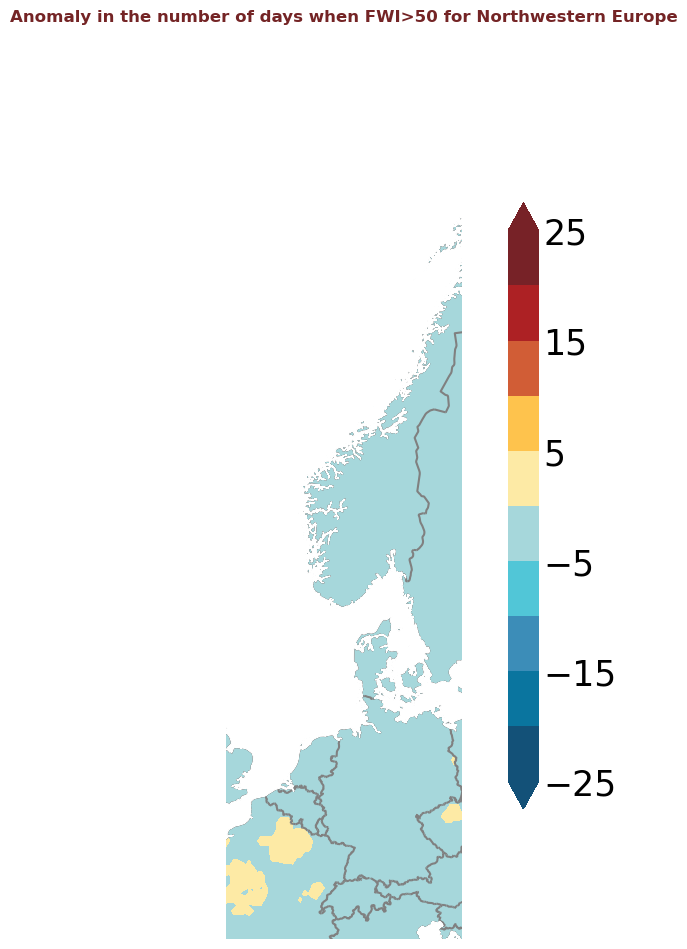

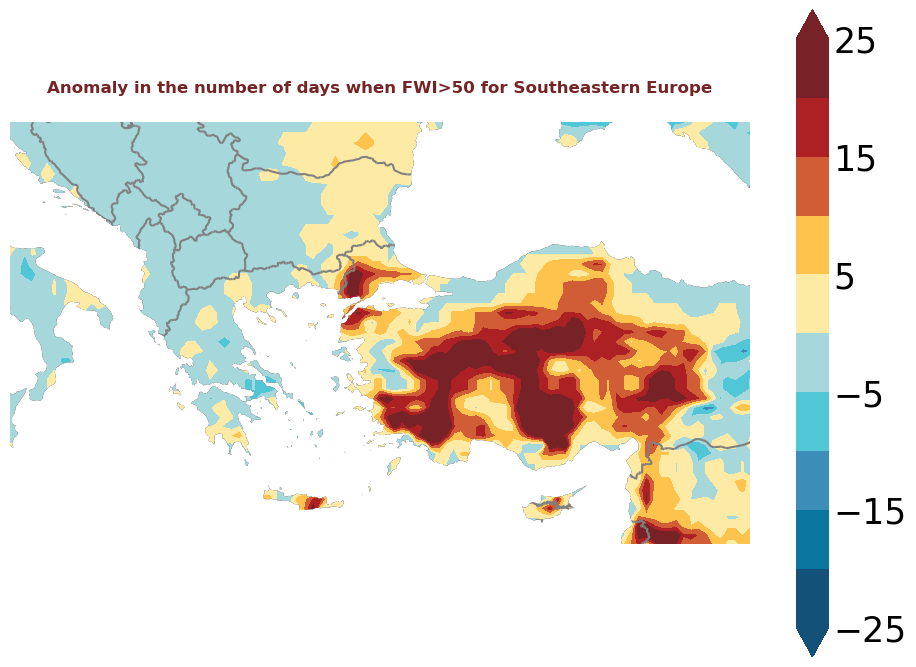

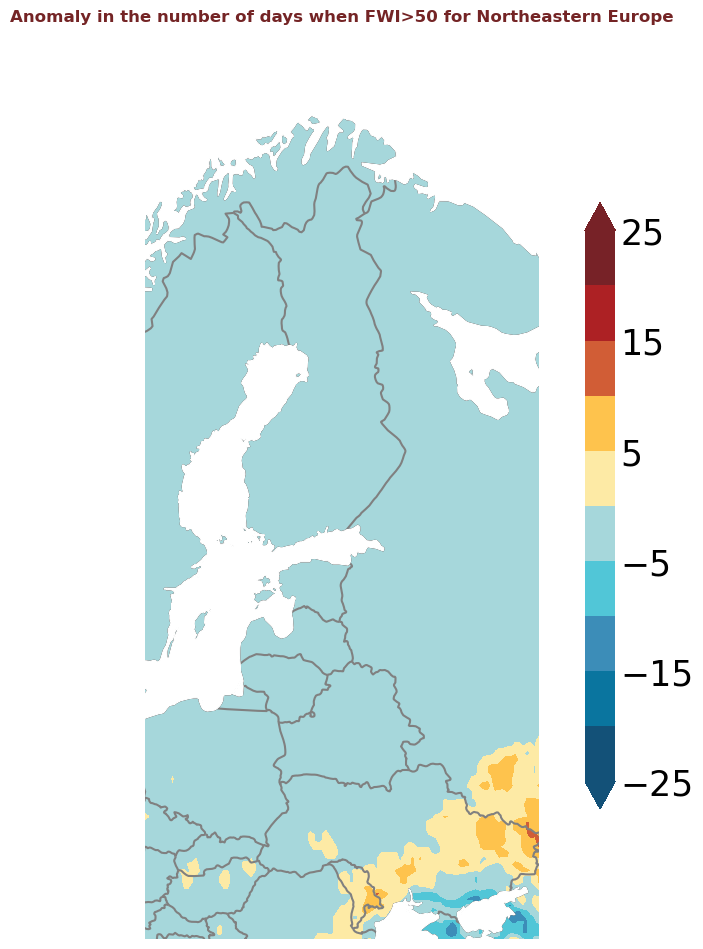

In [57]:
for key in esotc_regions:
    lon1=esotc_regions[key][0]
    lon2=esotc_regions[key][1]
    lat1=esotc_regions[key][2]
    lat2=esotc_regions[key][3]
    cymin=esotc_regions[key][4]
    cymax=esotc_regions[key][5]
    small = ds.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))
# Calculations
    last_y = small.sel(time=slice('2020-05-01T12:00:00.000000000','2020-09-30T12:00:00.000000000'))
    fwi_over50_2020 = last_y.fwi.where(last_y.fwi>50).groupby('time.year').count(dim='time')
    
    fwi_data_summer = small.sel(time=slice('2015-05-01', '2015-09-30'))
    fwi_over50 = fwi_data_summer.fwi.where(fwi_data_summer.fwi>50).groupby('time.year').count(dim='time')
    
    for year in range(2015,2019):
        fwi_data = ds.sel(time=slice(f'{year}-05-01', f'{year}-09-30'))
        x = fwi_data.fwi.where(fwi_data.fwi>50).groupby('time.year').count(dim='time')
        fwi_over50 = xr.concat([fwi_over50, x], dim='year')
    
    fwi_over50_mean = fwi_over50.mean(dim='year')
    anom = fwi_over50_2020.sel(year=2020) - fwi_over50_mean

# Plotting
    plt.figure(figsize=(10, 10), dpi=100)
    ax = plt.axes(projection=ccrs.Mercator())

    ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
    ax.add_feature(cart.feature.BORDERS, edgecolor='grey', lw=1.5)
    #ax.set_extent ((-15, 40, 34, 70), ccrs.PlateCarree())

    redblue = ['#135178', '#0a759f', '#3c8db8', '#51c6d7', '#a6d7db', '#fdeaa5', '#fec34d', '#d15d36', '#ad2124', '#772227']
    # Create the custom colormap
    my_cmap = (colors.ListedColormap(redblue))
    my_cmap.set_over('#772227')
    my_cmap.set_under('#135178')

    # Specify the number of discrete levels to use in the colormap
    bounds = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
    norm = colors.BoundaryNorm(bounds, my_cmap.N)

    # Plot data with contours and shading
    img = anom.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=11, extend='both',
                             add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=bounds[::2] )
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=0)

    #Add coastlines and title, remove black frame
    ax.coastlines()
    ax.set_frame_on(False)
    plt.title("Anomaly in the number of days when FWI>50 for " + key, fontsize=12, fontweight='bold', y=1.05, color='#742425')
    plt.tight_layout()
    #plt.savefig('./fwi_anom_europe_v_nowhite.tiff', format='tiff',facecolor='white')